<a href="https://colab.research.google.com/github/Shikhar777/Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries and Modules
import numpy as np
from PIL import Image
import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b


Using TensorFlow backend.


In [ ]:
#Hyper Parameters
ITERATIONS=10
CHANNELS=3
IMAGE_SIZE=500
IMAGE_HEIGHT=500
IMAGE_WIDTH=500
MEAN_RGB_VALUES=[123.68,116.779,103.939]
CONTENT_WEIGHT=0.02
STYLE_WEIGHT=4.5
TOTAL_VARIATION_WEIGHT=0.995
TOTAL_VARIATION_LOSS_FACTOR=1.25

In [ ]:
#Paths for Images
content_path="input.png"
style_path="style.png"
output_path="output.png"
combined_path="combined.png"

In [ ]:
#Uploading content image on Google Colab
from google.colab import files
img1=files.upload()


Saving japanese_garden.jpg to japanese_garden (1).jpg


In [ ]:
#Uploading style image on Google Colab
from google.colab import files
img2=files.upload()

Saving picasso_selfportrait.jpg to picasso_selfportrait (1).jpg


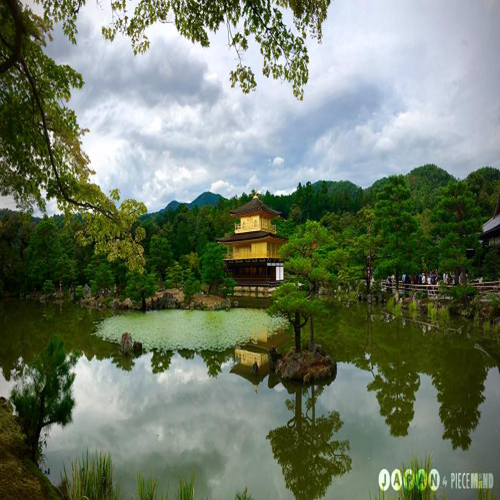

In [ ]:
#Content Visualization
content_image=Image.open('japanese_garden.jpg')
content_image=content_image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
content_image.save(content_path)
content_image

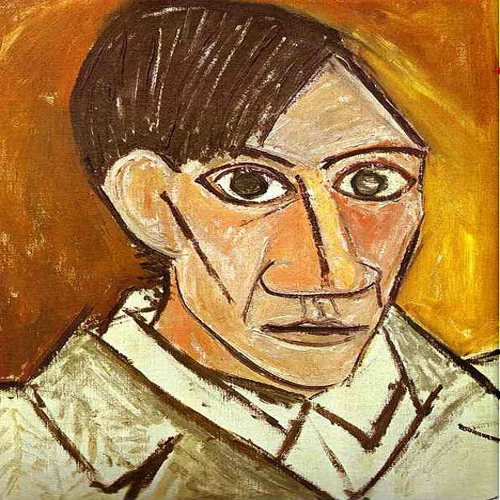

In [ ]:
#Style Visualization
style_image=Image.open('picasso_selfportrait.jpg')
style_image=style_image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
style_image.save(style_path)
style_image

In [ ]:
#Data Normalisation (Reshaping from RGB to BGR)
content_array=np.asarray(content_image,dtype="float32")
content_array=np.expand_dims(content_array,axis=0)
content_array[:, :, :, 0]-=MEAN_RGB_VALUES[2]
content_array[:, :, :, 1]-=MEAN_RGB_VALUES[1]
content_array[:, :, :, 2]-=MEAN_RGB_VALUES[0]
content_array=content_array[:, :, :, ::-1]

style_array=np.asarray(style_image,dtype="float32")
style_array=np.expand_dims(style_array,axis=0)
style_array[:, :, :, 0]-=MEAN_RGB_VALUES[2]
style_array[:, :, :, 1]-=MEAN_RGB_VALUES[1]
style_array[:, :, :, 2]-=MEAN_RGB_VALUES[0]
style_array=style_array[:, :, :, ::-1]

In [ ]:
#Building Model
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,IMAGE_HEIGHT,IMAGE_SIZE,3))
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)
model=VGG16(input_tensor=input_tensor,include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#Computation of Content Loss
def content_loss(content,combination):
    return backend.sum(backend.square(combination-content))
layers=dict([(layer.name,layer.output) for layer in model.layers])
content_layer="block2_conv2"
layer_features=layers[content_layer]
content_image_features=layer_features[0, :, :, :]
combination_features=layer_features[2, :, :, :]
loss=backend.variable(0.)
loss=loss+CONTENT_WEIGHT*content_loss(content_image_features,combination_features)


In [ ]:
#Building a Matrix
def matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    result=backend.dot(features,backend.transpose(features))
    return result

In [ ]:
#Computation of Style Loss
def compute_style_loss(style,combination):
    style=matrix(style)
    combination=matrix(combination)
    size=IMAGE_HEIGHT*IMAGE_WIDTH
    return backend.sum(backend.square(style-combination))/(4.*(CHANNELS**2)*(size**2))
style_layers=["block1_conv2","block2_conv2","block3_conv3","block4_conv3","block5_conv3"]
for layer_name in style_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1, :, :, :]
    combination_features=layer_features[2, :, :, :]
    style_loss=compute_style_loss(style_features,combination_features)
    loss=loss+(STYLE_WEIGHT/len(style_layers))*style_loss

In [ ]:
#Computation of Total Variation Loss
def total_variation_loss(x):
    a=backend.square(x[:,:IMAGE_HEIGHT-1,:IMAGE_WIDTH-1,:]-x[:,1:,:IMAGE_WIDTH-1,:])
    b=backend.square(x[:,:IMAGE_HEIGHT-1,:IMAGE_WIDTH-1,:]-x[:,:IMAGE_HEIGHT-1,1:,:])
    return backend.sum(backend.pow(a+b,TOTAL_VARIATION_LOSS_FACTOR))
loss=loss+TOTAL_VARIATION_WEIGHT*total_variation_loss(combination_image)


In [ ]:
#Computation of Outputs
outputs=[loss]
outputs=outputs+backend.gradients(loss,combination_image)
def evaluate_loss_and_gradients(x):
    x=x.reshape((1,IMAGE_HEIGHT,IMAGE_WIDTH,CHANNELS))
    outs=backend.function([combination_image],outputs)([x])
    loss=outs[0]
    gradients=outs[1].flatten().astype("float64")
    return loss,gradients
class Evaluator:
    def loss(self,x):
        loss,gradients=evaluate_loss_and_gradients(x)
        self._gradients=gradients
        return loss
    def gradients(self,x):
        return self._gradients
runner=Evaluator()

Iteration 0 completed with loss 81700495360
Iteration 1 completed with loss 36375822336
Iteration 2 completed with loss 24878075904
Iteration 3 completed with loss 20407830528
Iteration 4 completed with loss 18141155328
Iteration 5 completed with loss 16897564672
Iteration 6 completed with loss 16298235904
Iteration 7 completed with loss 15896459264
Iteration 8 completed with loss 15565860864
Iteration 9 completed with loss 15335682048


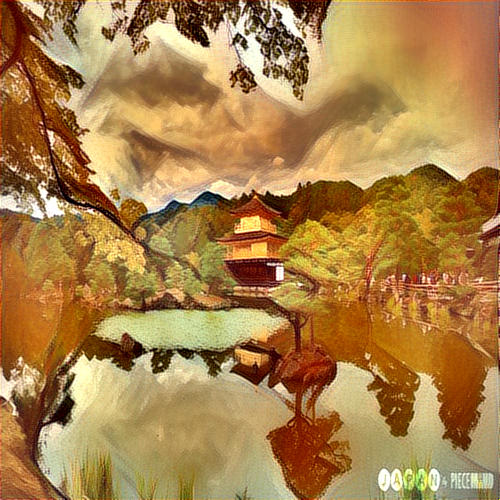

In [ ]:
#Running Iterations for Final Output Image
x=np.random.uniform(0,255,(1,IMAGE_HEIGHT,IMAGE_WIDTH,3))-128.
for i in range(ITERATIONS):
    x,loss,res=fmin_l_bfgs_b(runner.loss,x.flatten(),fprime=runner.gradients,maxfun=20)
    print("Iteration %d completed with loss %d" % (i,loss))    
x=x.reshape((IMAGE_HEIGHT,IMAGE_WIDTH,CHANNELS))
x=x[:, :, ::-1]
x[:,:,0]+=MEAN_RGB_VALUES[2]
x[:,:,1]+=MEAN_RGB_VALUES[1]
x[:,:,2]+=MEAN_RGB_VALUES[0]
x=np.clip(x,0,255).astype("uint8")
output_image=Image.fromarray(x)
output_image.save(output_path)
output_image

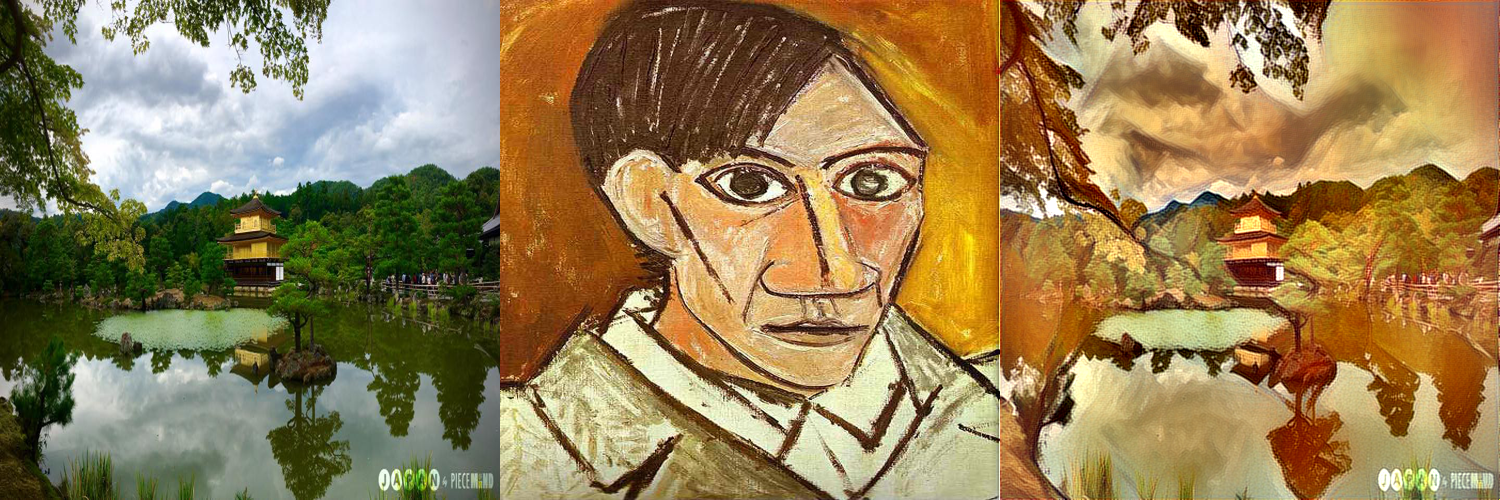

In [ ]:
#Visualization of the Combined Images
combined=Image.new("RGB",(IMAGE_WIDTH*3,IMAGE_HEIGHT))
x_offset=0
for image in map(Image.open,[content_path,style_path,output_path]):
    combined.paste(image,(x_offset,0))
    x_offset=x_offset+IMAGE_WIDTH
combined.save(combined_path)
combined